# TASK 1: EDA

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [9]:
print("Customers Dataset Info:")
customers.info()
customers.describe()

Customers Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


,CustomerID,CustomerName,Region,SignupDate
count,200,200,200,200
unique,200,200,4,179
top,C0001,Lawrence Carroll,South America,11/11/2024
freq,1,1,59,3


In [17]:
print("\nProducts Dataset Info:")
products.info()
products.describe()


Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB


,Price
count,100.000000
mean,267.551700
std,143.219383
min,16.080000
25%,147.767500
50%,292.875000
75%,397.090000
max,497.760000


In [19]:
print("\nTransactions Dataset Info:")
transactions.info()
transactions.describe()


Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


,Quantity,TotalValue,Price
count,1000.000000,1000.000000,1000.00000
mean,2.537000,689.995560,272.55407
std,1.117981,493.144478,140.73639
min,1.000000,16.080000,16.08000
25%,2.000000,295.295000,147.95000
50%,3.000000,588.880000,299.93000
75%,4.000000,1011.660000,404.40000
max,4.000000,1991.040000,497.76000


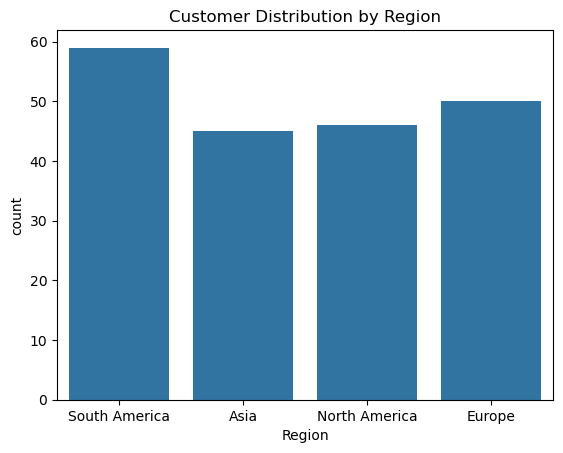

In [21]:
sns.countplot(x = "Region", data = customers)
plt.title("Customer Distribution by Region")
plt.show()

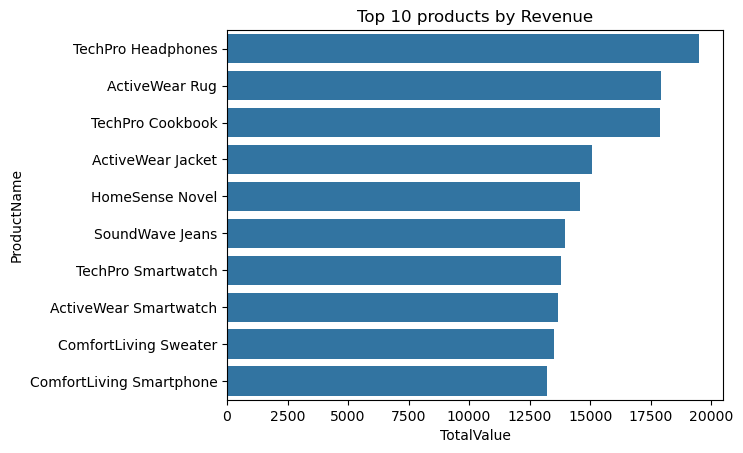

In [25]:
top_products = transactions.groupby('ProductID')['TotalValue'].sum().nlargest(10)
top_products = top_products.reset_index()
top_products = top_products.merge(products, on = 'ProductID')
sns.barplot(y = 'ProductName', x = 'TotalValue', data = top_products)
plt.title("Top 10 products by Revenue")
plt.show()

# TASK 2: Lookalike Model

In [35]:
data = pd.merge(transactions, customers, on = 'CustomerID')
data = pd.merge(data, products, on = 'ProductID')
data.rename(columns={'Price_x': 'Price'}, inplace=True)
data.drop(columns=['Price_y'], inplace=True)
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate,ProductName,Category
0,T00001,C0199,P067,8/25/2024 12:38,1,300.68,300.68,Andrea Jenkins,Europe,12/3/2022,ComfortLiving Bluetooth Speaker,Electronics
1,T00112,C0146,P067,5/27/2024 22:23,1,300.68,300.68,Brittany Harvey,Asia,9/4/2024,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,4/25/2024 7:38,1,300.68,300.68,Kathryn Stevens,Europe,4/4/2024,ComfortLiving Bluetooth Speaker,Electronics
3,T00272,C0087,P067,3/26/2024 22:55,2,601.36,300.68,Travis Campbell,South America,4/11/2024,ComfortLiving Bluetooth Speaker,Electronics
4,T00363,C0070,P067,3/21/2024 15:10,3,902.04,300.68,Timothy Perez,Europe,3/15/2022,ComfortLiving Bluetooth Speaker,Electronics


In [39]:
customer_profiles = data.groupby("CustomerID").agg({
    "Quantity": "sum",
    "TotalValue": "sum",
    "Price": "mean"
}).reset_index()
customer_profiles.head()

,CustomerID,Quantity,TotalValue,Price
0,C0001,12,3354.52,278.334000
1,C0002,10,1862.74,208.920000
2,C0003,14,2725.38,195.707500
3,C0004,23,5354.88,240.636250
4,C0005,7,2034.24,291.603333


In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
profile_matrix = scaler.fit_transform(customer_profiles.drop("CustomerID", axis = 1))

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(profile_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index = customer_profiles['CustomerID'], columns = customer_profiles['CustomerID'])

In [51]:
lookalike_results = {}
for customer in similarity_df.index[:20]:
    similar_customers = similarity_df[customer].nlargest(4).iloc[1:]
    lookalike_results[customer] = list(zip(similar_customers.index, similar_customers.values))

In [53]:
lookalike_df = pd.DataFrame([
    {"CustomerID": k, "Recommendations": v}
    for k, v in lookalike_results.items()
])
lookalike_df.to_csv('Lookalike.csv', index = False)
print("Lookalike recommendations saved to Lookalike.csv.")

Lookalike recommendations saved to Lookalike.csv.


# TASK 3: Customer Segmentation

In [61]:
data = pd.merge(transactions, customers, on="CustomerID")
data = pd.merge(data, products, on="ProductID")
data.rename(columns={'Price_x': 'Price'}, inplace=True)
data.drop(columns=['Price_y'], inplace=True)
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate,ProductName,Category
0,T00001,C0199,P067,8/25/2024 12:38,1,300.68,300.68,Andrea Jenkins,Europe,12/3/2022,ComfortLiving Bluetooth Speaker,Electronics
1,T00112,C0146,P067,5/27/2024 22:23,1,300.68,300.68,Brittany Harvey,Asia,9/4/2024,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,4/25/2024 7:38,1,300.68,300.68,Kathryn Stevens,Europe,4/4/2024,ComfortLiving Bluetooth Speaker,Electronics
3,T00272,C0087,P067,3/26/2024 22:55,2,601.36,300.68,Travis Campbell,South America,4/11/2024,ComfortLiving Bluetooth Speaker,Electronics
4,T00363,C0070,P067,3/21/2024 15:10,3,902.04,300.68,Timothy Perez,Europe,3/15/2022,ComfortLiving Bluetooth Speaker,Electronics


In [63]:
customer_features = data.groupby("CustomerID").agg({
    "Quantity": "sum",
    "TotalValue": "sum",
    "Price": "mean"
}).reset_index()

In [67]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop("CustomerID", axis=1))

In [71]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5, random_state = 42)
clusters = kmeans.fit_predict(scaled_features)
customer_features['Cluster'] = clusters

C:\Users\adib\OneDrive\Documents\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [73]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.9467058109377833


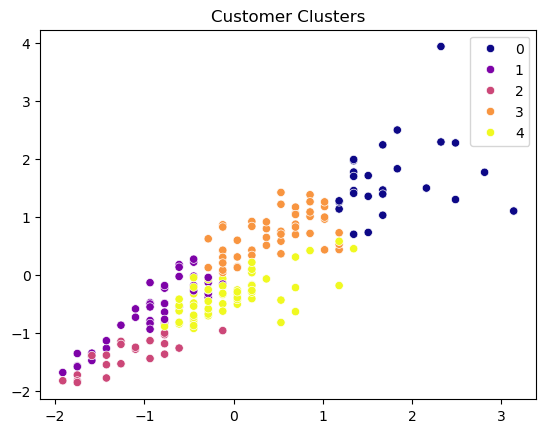

In [85]:
sns.scatterplot(
    x = scaled_features[:, 0], y = scaled_features[:, 1], hue = clusters, palette = "plasma"
)
plt.title("Customer Clusters")
plt.show()

In [89]:
customer_features.to_csv("Clustering_Results.csv", index=False)
print("Clustering results saved to Clustering_Results.csv.")

Clustering results saved to Clustering_Results.csv.
